# Simple Visulization

In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.dates as mdates
import pickle
import json
import seaborn as sns
sns.set_theme()
# import pygmt

# dir_name = "Ridgecrest_demo"
# dir_name = "Ridgecrest_oneweek"
# dir_name = "Ridgecrest"
# dir_name = "SaltonSea"
# dir_name = "SanSimeon"
# dir_name = "Ridgecrest"
# dir_name = "Italy"
# dir_name = "Hawaii"
dir_name = "PuertoRico"
# dir_name = "Tahoe"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
root_dir = lambda x: os.path.join(dir_name, x)

In [2]:
result_label="QuakeFlow"
catalog_label="Standard"
# catalog_label="SCSN"
# catalog_label="IRIS"
# catalog_file = "catalog.csv"
# picks_file = "picks.csv"
catalog_file = "merged_catalog.csv"
picks_file = "merged_picks.csv"

hypodd_file = "hypoDD_catalog.txt"

In [3]:
with open(root_dir("config.json"), "r") as fp:
    config = json.load(fp)
stations = pd.read_csv(root_dir("stations.csv"), delimiter="\t")
events = pd.read_csv(root_dir("events.csv"), delimiter="\t")
events["time"] = events["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

catalog = pd.read_csv(root_dir(catalog_file), delimiter="\t")
catalog["time"] = catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
catalog["covariance"] = catalog["covariance"].apply(lambda x: [float(i) for i  in x.split(",")])

catalog_hypoDD = pd.read_csv(root_dir(hypodd_file), sep="\s+", names=["ID", "LAT", "LON", "DEPTH", "X", "Y", "Z", "EX", "EY", "EZ", "YR", "MO", "DY", "HR", "MI", "SC", "MAG", "NCCP", "NCCS", "NCTP",
"NCTS", "RCC", "RCT", "CID"])
catalog_hypoDD["time"] = catalog_hypoDD.apply(lambda x: f'{x["YR"]:04.0f}-{x["MO"]:02.0f}-{x["DY"]:02.0f}T{x["HR"]:02.0f}:{x["MI"]:02.0f}:{min(x["SC"], 59.999):05.3f}', axis=1)
catalog_hypoDD["time"] = catalog_hypoDD["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
catalog_hypoDD["latitude"] = catalog_hypoDD["LAT"]
catalog_hypoDD["longitude"] = catalog_hypoDD["LON"]
catalog_hypoDD["depth(m)"] = catalog_hypoDD["DEPTH"] * 1e3
catalog_hypoDD["magnitude"] = catalog_hypoDD["MAG"] 

catalog = catalog_hypoDD

marker_size = 0.1
bins = min(len(catalog["time"])//40 + 10, 40)

In [4]:
# region = config["xlim_degree"] + config["ylim_degree"]
# fig = pygmt.Figure()
# fig.basemap(region=region, projection="M8i", frame=True)
# fig.grdimage("@earth_relief_15s", cmap="topo", shading=True)
# # fig.grdimage("@earth_relief_15s", cmap="sealand", shading=True)
# fig.plot(x=stations["longitude"], y=stations["latitude"], style="t0.5", color="blue", pen="black", label="Station")
# fig.savefig(root_dir(f"stations-{dir_name.lower()}.png"))
# fig.savefig(root_dir(f"stations-{dir_name.lower()}.pdf"))
# fig.show()

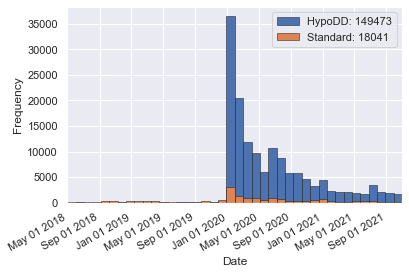

In [5]:
plt.figure()
# plt.hist(catalog["time"], range=(config["starttime"], config["endtime"]), bins=bins, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(catalog['time'])}")
plt.hist(catalog["time"], range=(config["starttime"], config["endtime"]), bins=bins, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"HypoDD: {len(catalog_hypoDD['time'])}")
plt.hist(events["time"], range=(config["starttime"], config["endtime"]), bins=bins, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{catalog_label}: {len(events['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
# plt.yscale("log")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(root_dir("earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("earthquake_number.pdf"), bbox_inches="tight")
plt.show()

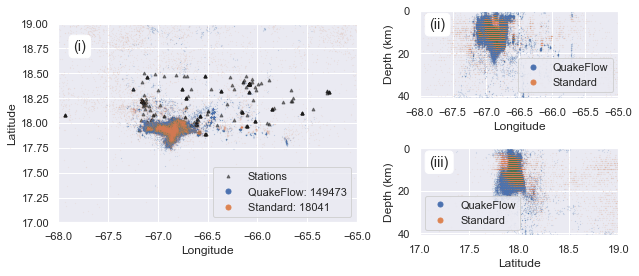

In [6]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=3, alpha=0.5, label="Stations")
plt.plot(catalog["longitude"], catalog["latitude"], '.',markersize=marker_size, alpha=1.0, rasterized=True)
plt.plot(events["longitude"], events["latitude"], '.', markersize=marker_size, alpha=0.6, rasterized=True)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))#+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"]))#+np.array([0.2,-0.27]))
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{result_label}: {len(catalog['time'])}")
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{catalog_label}: {len(events['time'])}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(catalog["longitude"], catalog["depth(m)"]/1e3, '.', markersize=marker_size, alpha=1.0, rasterized=True)
plt.plot(events["longitude"], events["depth(m)"]/1e3, '.', markersize=marker_size, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"]))#+np.array([0.2,-0.27]))
# plt.ylim([0,21])
plt.ylim(bottom=0, top=41)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(catalog["latitude"], catalog["depth(m)"]/1e3, '.', markersize=marker_size, alpha=1.0, rasterized=True)
plt.plot(events["latitude"], events["depth(m)"]/1e3, '.', markersize=marker_size, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"]))#+np.array([0.2,-0.27]))
# plt.ylim([0,21])
plt.ylim(bottom=0, top=41)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower left")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(root_dir("earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show()

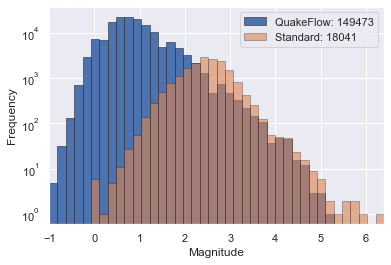

In [7]:
# catalog["magnitude"] += np.log(np.sqrt(2))
plt.figure()
xrange = (-1., max(events["magnitude"].max(), catalog["magnitude"].max()))
# xrange = (-1., events["magnitude"].max())
plt.hist(catalog["magnitude"], range=xrange, bins=bins, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(catalog['magnitude'])}")
# plt.hist(catalog_hypoDD["magnitude"], range=xrange, bins=bins, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.hist(events["magnitude"], range=xrange, bins=bins, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
plt.xlim(xrange)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.gca().set_yscale('log')
plt.savefig(root_dir("earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
plt.show()

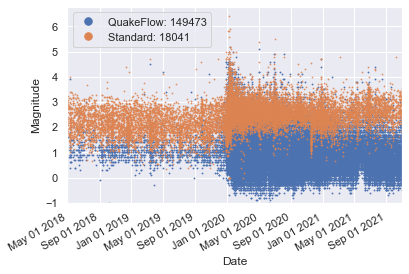

In [8]:
plt.figure()
plt.plot(catalog["time"], catalog["magnitude"], '.', markersize=marker_size+1.5, alpha=1.0, rasterized=True)
plt.plot(events["time"], events["magnitude"], '.', markersize=marker_size+1.5, alpha=0.8, rasterized=True)
plt.xlim(config["starttime"], config["endtime"])
# plt.ylim(top=events["magnitude"].max())
ylim = plt.ylim(bottom=-1)
xlim = plt.xlim()
plt.ylabel("Magnitude")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.plot(datetime.fromisoformat(config["starttime"]), -10, '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
plt.xlim(xlim)
plt.ylim(ylim)
# plt.grid()
plt.savefig(root_dir("earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(root_dir("earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show();

In [9]:
# covariance = np.array(catalog["covariance"].to_list())

# fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
# box = dict(boxstyle='round', facecolor='white', alpha=1)
# text_loc = [0.05, 0.90]
# plt.subplot(311)
# plt.plot(catalog["time"], covariance[:,0], '.', markersize=marker_size, label="Travel-time", rasterized=True)
# plt.ylim([0, 3])
# plt.ylabel(r"$\Sigma_{11}$ (s)$^2$")
# plt.legend(loc="upper right")
# plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
#          transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
# plt.subplot(312)
# plt.plot(catalog["time"], covariance[:,1], '.', markersize=marker_size, label="Amplitude", rasterized=True)
# plt.ylim([0, 1])
# plt.ylabel(r"$\Sigma_{22}$ ($\log10$ m/s)$^2$")
# plt.legend(loc="upper right")
# plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
#          transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
# plt.subplot(313)
# plt.plot(catalog["time"], covariance[:,2], '.', markersize=marker_size, label="Travel-time vs. Amplitude", rasterized=True)
# plt.ylabel(r"$\Sigma_{12}$")
# plt.ylim([-0.5, 0.7])
# plt.legend(loc="upper right")
# plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
#          transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
# plt.gcf().autofmt_xdate()
# # plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
# plt.tight_layout()
# plt.gcf().align_labels()
# plt.savefig(root_dir("covariance.png"), bbox_inches="tight", dpi=300)
# plt.savefig(root_dir("covariance.pdf"), bbox_inches="tight")
# plt.show();